## Importing Modules and Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = '''SELECT
         name,
         type
        FROM sqlite_master
        WHERE type IN ("table","view");'''
    return run_query(q)

show_tables()

name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table

## Top Genres Based on USA Sales

In [3]:
q1 = '''SELECT 
            il.invoice_line_id,
            il.track_id,
            i.billing_country,
            c.country
        FROM invoice_line il
        INNER JOIN invoice i on il.invoice_id = i.invoice_id
        INNER JOIN customer c on i.customer_id = c.customer_id
        WHERE c.country="USA"'''
usa_purchase = run_query(q1)
print(usa_purchase.head(10))

   invoice_line_id  track_id billing_country country
0                1      1158             USA     USA
1                2      1159             USA     USA
2                3      1160             USA     USA
3                4      1161             USA     USA
4                5      1162             USA     USA
5                6      1163             USA     USA
6                7      1164             USA     USA
7                8      1165             USA     USA
8                9      1166             USA     USA
9               10      1167             USA     USA


In [37]:
q2 = '''WITH usa_purchase AS
          (SELECT 
            il.invoice_line_id,
            il.track_id,
            i.billing_country,
            c.country
        FROM invoice_line il
        INNER JOIN invoice i on il.invoice_id = i.invoice_id
        INNER JOIN customer c on i.customer_id = c.customer_id
        WHERE c.country="USA")
        
        SELECT
            g.name as genre,
            count(*) as sales
        FROM genre g
        INNER JOIN track t on t.genre_id=g.genre_id
        INNER JOIN usa_purchase up on up.track_id=t.track_id
        GROUP BY 1
        ORDER BY 2 desc
        '''
usa_genre_sales = run_query(q2)
print(usa_genre_sales)

                 genre  sales
0                 Rock    561
1   Alternative & Punk    130
2                Metal    124
3             R&B/Soul     53
4                Blues     36
5          Alternative     35
6                Latin     22
7                  Pop     22
8          Hip Hop/Rap     20
9                 Jazz     14
10      Easy Listening     13
11              Reggae      6
12   Electronica/Dance      5
13           Classical      4
14         Heavy Metal      3
15          Soundtrack      2
16            TV Shows      1


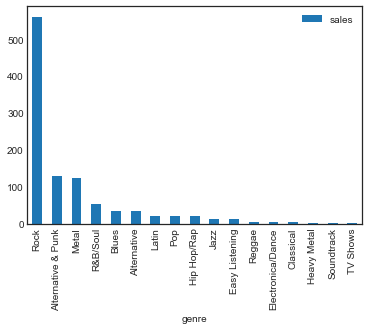

In [38]:
usa_genre_sales.set_index('genre', drop=True, inplace=True)
usa_genre_sales.plot.bar()

In [6]:
usa_genre_sales['percentage']= usa_genre_sales['sales']/sum(usa_genre_sales['sales'])

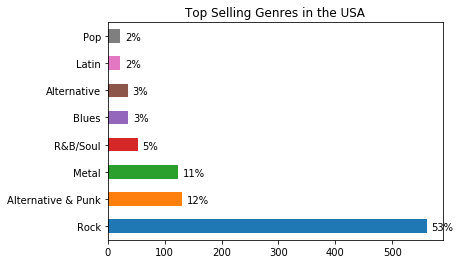

In [7]:
top_genres = usa_genre_sales.loc[usa_genre_sales['percentage']>0.02]
top_genres.plot.barh(y='sales',
         title="Top Selling Genres in the USA")
plt.ylabel('')
plt.legend().set_visible(False)

for i, label in enumerate(list(top_genres.index)):
    score = top_genres.loc[label,'sales']
    label = (top_genres.loc[label, 'percentage']*100).astype(int).astype(str)+'%'
    plt.annotate(label, (score+8, i-0.15))

Rock is by far the best selling genre, accounting for over half of the sales.

## Analyzing Employee Sales Performance

In [8]:
q3 = '''SELECT 
            e.first_name|| ' '||e.last_name as employee_name,
            e.birthdate,
            e.hire_date,
            sum(i.total) total_sales
        FROM employee e 
        INNER JOIN customer c on e.employee_id=c.support_rep_id
        INNER JOIN invoice i on c.customer_id=i.customer_id
        WHERE title ="Sales Support Agent"
        GROUP BY 1,2,3'''
run_query(q3)

employee_name            birthdate            hire_date  total_sales
0   Jane Peacock  1973-08-29 00:00:00  2017-04-01 00:00:00      1731.51
1  Margaret Park  1947-09-19 00:00:00  2017-05-03 00:00:00      1584.00
2  Steve Johnson  1965-03-03 00:00:00  2017-10-17 00:00:00      1393.92

The difference among the three sales support agents' total sales is not very large, and it may be explained by their hire dates: The earlier an employee was hired, the more sales he/she has made.

## Analyzing Sales by Country

In [5]:
q4 = '''WITH 
          sales_by_country AS         
        (SELECT
            CASE 
               WHEN (SELECT count(customer_id)
                     FROM customer
                     WHERE country=c.country
                     ) = 1 THEN 'Other'
                ELSE c.country
             END AS country,
            COUNT(distinct(c.customer_id)) number_of_customers,
            SUM(i.total) total_sales,
            SUM(i.total)/COUNT(DISTINCT(c.customer_id)) avg_sales_per_customer,
            SUM(i.total)/COUNT(i.invoice_id) avg_order_value
        FROM customer c
        INNER JOIN invoice i on c.customer_id=i.customer_id
        GROUP BY 1),
        
           sales_by_country_reorder AS 
         (SELECT 
             sbc.*,
             CASE
                WHEN sbc.country = "Other" THEN 1
                ELSE 0
             END AS sort_other
           FROM sales_by_country sbc
           ORDER BY sort_other, sbc.total_sales DESC)
        
        SELECT
            country, 
            number_of_customers,
            total_sales,
            avg_sales_per_customer,
            avg_order_value
        FROM sales_by_country_reorder
        '''
sales_by_country = run_query(q4)
sales_by_country.set_index('country', drop=True, inplace=True)
print(sales_by_country)

                number_of_customers  total_sales  avg_sales_per_customer  \
country                                                                    
USA                              13      1040.49               80.037692   
Canada                            8       535.59               66.948750   
Brazil                            5       427.68               85.536000   
France                            5       389.07               77.814000   
Germany                           4       334.62               83.655000   
Czech Republic                    2       273.24              136.620000   
United Kingdom                    3       245.52               81.840000   
Portugal                          2       185.13               92.565000   
India                             2       183.15               91.575000   
Other                            15      1094.94               72.996000   

                avg_order_value  
country                          
USA                

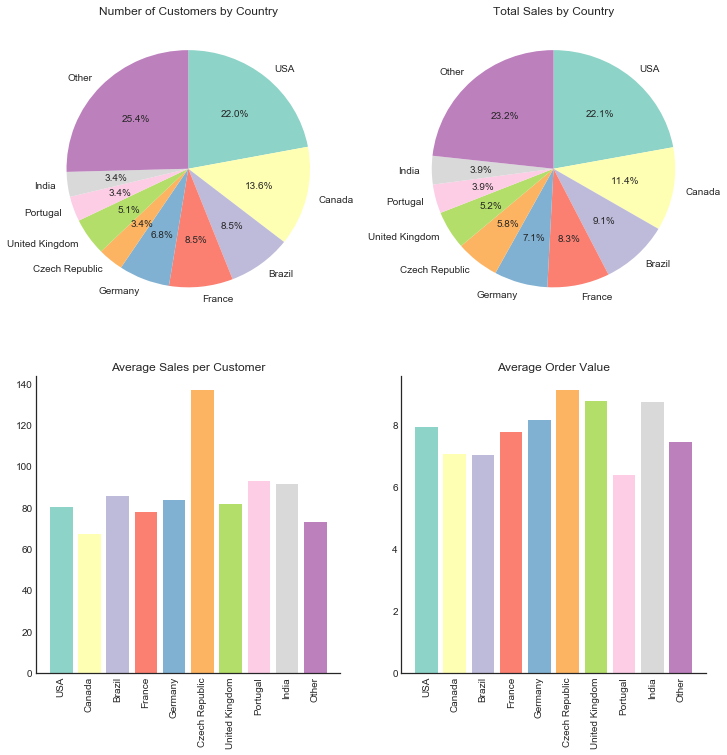

In [16]:
fig = plt.figure(figsize=(12,12))
cols = ['number_of_customers','total_sales','avg_sales_per_customer',
       'avg_order_value']
titles = ['Number of Customers by Country',
         'Total Sales by Country',
         'Average Sales per Customer',
         'Average Order Value']
colors = [plt.cm.Set3(i) for i in range(sales_by_country.shape[0])]
for i in range(4):
    sns.set_style('white')
    ax = fig.add_subplot(2,2,1+i)
    df = sales_by_country
    
    # pie charts for number of customers and total sales
    if i < 2:
        df[cols[i]].plot.pie(
            startangle=90,
            counterclock=False,
            title=titles[i],
            autopct='%1.1f%%',
            colors=colors,
            fontsize=10,
            wedgeprops={'linewidth':0})
        ax.set_ylabel('')
        
    # bar plots for average sales and order value
    else:
        ax.bar(np.arange(len(df))+0.5, df[cols[i]], 
               width = 0.8, color = colors)
        ax.set_xticks(np.arange(len(df))+0.5)
        ax.set_xticklabels(df.index, rotation = 90)
        ax.set_title(titles[i])
    sns.despine()
    

While USA has the most customers and total sales, Czech Republic has by far the highest average sales per customer. Czech Republic, United Kingdom and India have the highest average order values, so we can consider more campaigns in these countries.

## Albums vs Individual Track Purchase

In [11]:
q5 = '''WITH 
          album_tracks AS
            (SELECT
                a.album_id,
                t.track_id
            FROM album a
            INNER JOIN track t on a.album_id=t.album_id),
        
          album_track_count AS
            (SELECT
                album_id, 
                COUNT(DISTINCT(track_id)) number_of_tracks_in_album
             FROM album_tracks
             GROUP BY 1),
            
          invoice_tracks AS
            (SELECT
                i.invoice_id,
                il.track_id,
                at.album_id,
                atc.number_of_tracks_in_album
             FROM invoice i
             INNER JOIN invoice_line il on i.invoice_id=il.invoice_id
             INNER JOIN album_tracks at on at.track_id=il.track_id
             INNER JOIN album_track_count atc on atc.album_id=at.album_id
             ORDER BY 1),
        
          purchase_type as
          (SELECT 
            it.invoice_id,
            CASE 
               WHEN COUNT(DISTINCT(it.album_id)) > 1 THEN "track"
               WHEN COUNT(DISTINCT(it.track_id)) = 
                 (SELECT it2.number_of_tracks_in_album
                   FROM invoice_tracks it2
                   WHERE it2.invoice_id=it.invoice_id
                   LIMIT 1) THEN "album"
                ELSE "track"
                END AS album_or_track
            FROM invoice_tracks it
            GROUP BY 1)
            
           SELECT 
              album_or_track,
              COUNT(invoice_id) as number_of_invoices,
              CAST(COUNT(invoice_id) AS FLOAT)/(
                   SELECT COUNT(*) FROM purchase_type) as percentage
           FROM purchase_type
           GROUP BY album_or_track
            
          '''
run_query(q5)

album_or_track  number_of_invoices  percentage
0          album                 114    0.185668
1          track                 500    0.814332

Most of the purchases are by individual tracks, but whole album purchases still account for nearly 20% of the sales.

## Which artist is used in the most playlists?

In [36]:
q6 = '''WITH
          playlist_artist AS
        (SELECT
            pt.playlist_id,
            al.artist_id,
            ar.name
         FROM playlist_track pt
         INNER JOIN track t ON pt.track_id = t.track_id
         INNER JOIN album al ON al.album_id = t.album_id
         INNER JOIN artist ar ON ar.artist_id = al.artist_id)
         
         SELECT 
             artist_id,
             name,
             COUNT(DISTINCT(playlist_id)) number_of_playlists
         FROM playlist_artist 
         GROUP BY 1, 2
         ORDER BY 3 DESC
         LIMIT 10'''

run_query(q6)

artist_id                                               name  \
0        226                                     Eugene Ormandy   
1        208                   English Concert & Trevor Pinnock   
2        214  Academy of St. Martin in the Fields & Sir Nevi...   
3        247                                 The King's Singers   
4        248      Berliner Philharmoniker & Herbert Von Karajan   
5        206             Alberto Turco & Nova Schola Gregoriana   
6        207  Richard Marlow & The Choir of Trinity College,...   
7        211                                     Wilhelm Kempff   
8        212                                           Yo-Yo Ma   
9        213                          Scholars Baroque Ensemble   

   number_of_playlists  
0                    7  
1                    6  
2                    6  
3                    6  
4                    6  
5                    5  
6                    5  
7                    5  
8                    5  
9                    5

We can see the artist Eugene Ormandy appeared in most (7) playlists.

## How many tracks have been purchased vs not purchased?

In [22]:
q7 = '''SELECT 
            COUNT(DISTINCT(track_id)) AS tracks_purchased,
            (SELECT COUNT(*) FROM track) AS total_tracks,
            CAST(COUNT(DISTINCT(track_id)) AS FLOAT)/(
            SELECT COUNT(*) FROM track) AS percentage_purchased
        FROM invoice_line 
        '''
run_query(q7)

tracks_purchased  total_tracks  percentage_purchased
0              1806          3503              0.515558

The data shows that only slightly over half of the tracks have been purchased.

## Do protected vs non-protected media types have an effect on popularity?

In [21]:
q8 = '''SELECT * FROM media_type'''
run_query(q8)

media_type_id                         name
0              1              MPEG audio file
1              2     Protected AAC audio file
2              3  Protected MPEG-4 video file
3              4     Purchased AAC audio file
4              5               AAC audio file

In [28]:
q9 = '''WITH
          track_purchase AS
        (SELECT 
          track_id,
          media_type,
          COUNT(invoice_line_id) number_of_purchase
       FROM 
         (SELECT
            t.track_id,
            il.invoice_line_id,
            mt.name media_type
         FROM track t
         LEFT JOIN invoice_line il ON t.track_id = il.track_id
         LEFT JOIN media_type mt ON t.media_type_id = mt.media_type_id)
       GROUP BY 1),
       
       track_purchase_update AS
       (SELECT 
          tp.*,
          CASE
            WHEN tp.number_of_purchase > 0 THEN 'Yes'
            ELSE 'No'
            END AS purchased,
          CASE
            WHEN tp.media_type LIKE 'Protected%' THEN 'Protected'
            ELSE 'Not Protected'
            END AS protected_status
       FROM track_purchase tp)
       
       SELECT 
           protected_status,
           purchased,
           COUNT(track_id)
       FROM track_purchase_update
       GROUP BY 1,2
       '''

run_query(q9)

protected_status purchased  COUNT(track_id)
0    Not Protected        No             1400
1    Not Protected       Yes             1652
2        Protected        No              297
3        Protected       Yes              154

The data shows protected tracks are less likely to be purchased than non-protected ones.